<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210917_%E7%89%B9%E5%BE%B4%E9%87%8F_%E6%89%8B%E5%8B%95_%E3%81%AE%E5%86%8D%E8%A6%B3%E5%AF%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data',
 '210904_学習データの読み込み.ipynb',
 '210906_EDA_train.ipynb',
 '210908_EDA_test.ipynb',
 '210908_テストデータの読み込み_作成.ipynb',
 '210909_特徴量エンジニアリング.ipynb',
 '210912_特徴量E_連続処理_モデル検討_OneClassSVM.ipynb',
 '210916_モデル検討_AE_ペンディング.ipynb',
 '210917_特徴量(手動)の再観察.ipynb']

In [ ]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [ ]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

In [ ]:
#%time
#DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
#C = 'Discharge'

def data_reading(DATA_DIR, C):

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
              'Voltage Measured (V)' : 'VM',
              'Voltage Charge (V)' : 'VC',
              'Current Measured (Amps)' : 'CM', 
              'Current Charge (Amps)' : 'CC',
              'Temperature (degree C)': 'Temp', 
              'unit' : 'unit_name', 
              'charge_mode' : 'mode', 
              'Cycle_num' : 'Cycle',
              'Voltage Load (V)' : 'VL',
              'Current Load (Amps)' : 'CL'
  }

  df_list = []
  for folder in tqdm(os.listdir(DATA_DIR)[:3]):
    files = glob.glob(os.path.join(DATA_DIR, folder, C, '*.csv'))
    df_list_0 = []
    for file in files:
      tmp_df = pd.read_csv(file, encoding='utf-8')
      tmp_df = tmp_df.rename(columns=col_list)
      #ユニット名、充・放電モード、サイクル数の取得
      unit, charge_mode, cycle_num = get_some_values(file)
      #特徴量のデータフレームの作成
      if C == 'Charge':
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_c_vm' : featured_c_vm(tmp_df),
                          'feature_c_cm' : featured_c_cm(tmp_df),
                          'feature_c_vc' : featured_c_vc(tmp_df)}])
      else:
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_d_vm' : featured_d_vm(tmp_df),
                          'feature_d_vl' : featured_d_vl(tmp_df)}])
      df_list_0.append(df_exp)
    df_0 = pd.concat(df_list_0)
    df_list.append(df_0)
  df = pd.concat(df_list)

  #ユニットとサイクルでソート。
  df = df.sort_values(['unit', 'Cycle_num'])
  #インデックスの振り直し
  df = df.reset_index(drop=True)

  return df

In [ ]:
def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

# 学習データ

In [ ]:
%time
#データの読み込み(学習)
#充電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_train_charge = data_reading(DATA_DIR, C)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


In [ ]:
df_train_charge.head()

,unit,charge_mode,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9


In [ ]:
%time
#データの読み込み(学習)
#放電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_train_discharge = data_reading(DATA_DIR, C)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


100%|██████████| 3/3 [00:57<00:00, 19.32s/it]


In [ ]:
df_train_discharge.head()

,unit,charge_mode,Cycle_num,feature_d_vm,feature_d_vl
0,Train_Unit_1,Discharge,1,3346.9,3327.2
1,Train_Unit_1,Discharge,2,3328.8,3309.2
2,Train_Unit_1,Discharge,3,3309.4,3289.8
3,Train_Unit_1,Discharge,4,3309.7,3289.9
4,Train_Unit_1,Discharge,5,3307.7,3287.9


In [ ]:
#充電と放電の特徴量のデータセット作成
df_train_feature = pd.merge(df_train_charge, df_train_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_train_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9


In [ ]:
df_train_feature[df_train_feature['unit'] == 'Train_Unit_3' ].corr()

,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,feature_d_vm,feature_d_vl
Cycle_num,1.000000,0.091781,0.047239,-0.866296,-0.822433,-0.826937
feature_c_vm,0.091781,1.000000,0.362748,0.188407,0.121339,0.118008
feature_c_cm,0.047239,0.362748,1.000000,0.187434,0.157292,0.154327
feature_c_vc,-0.866296,0.188407,0.187434,1.000000,0.945769,0.946816
feature_d_vm,-0.822433,0.121339,0.157292,0.945769,1.000000,0.999967
feature_d_vl,-0.826937,0.118008,0.154327,0.946816,0.999967,1.000000


In [ ]:
print(df_train['unit'].unique())
print(df_train.columns)
print(df_train.columns[3:])

['Train_Unit_1' 'Train_Unit_2' 'Train_Unit_3']
Index(['unit', 'charge_mode', 'Cycle_num', 'feature_c_vm', 'feature_c_cm',
       'feature_c_vc'],
      dtype='object')
Index(['feature_c_vm', 'feature_c_cm', 'feature_c_vc'], dtype='object')


In [ ]:
feature_col = df_train_feature.columns[3:6]
feature_col = feature_col.append(df_train_feature.columns[7:])
feature_col

Index(['feature_c_vm', 'feature_c_cm', 'feature_c_vc', 'feature_d_vm',
       'feature_d_vl'],
      dtype='object')

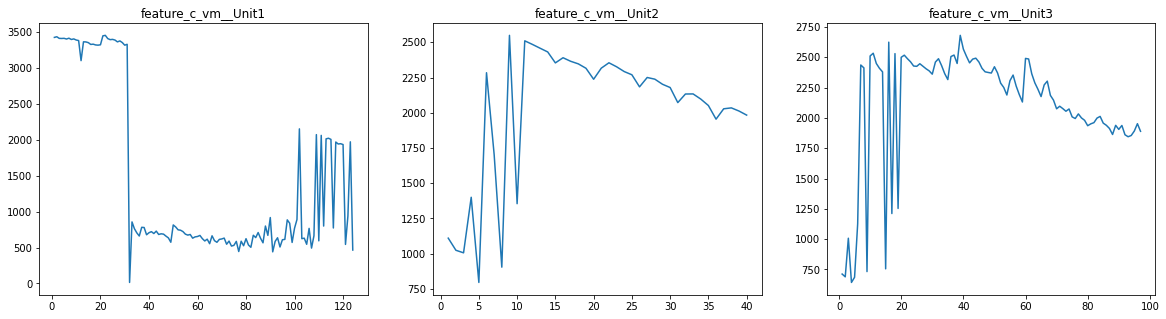

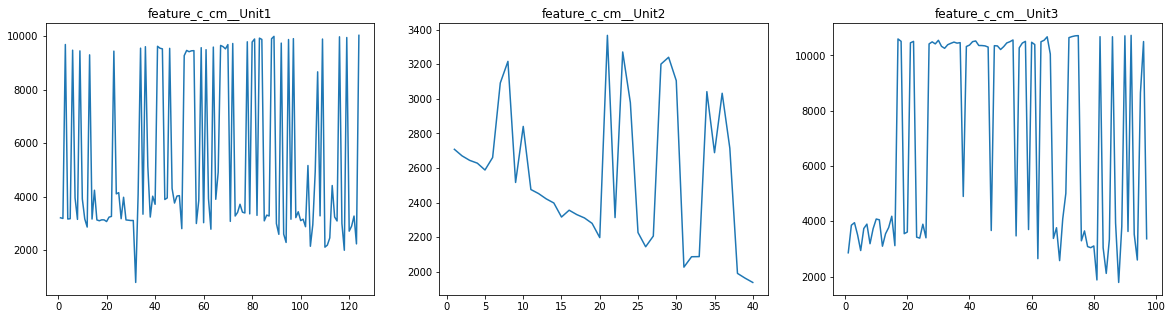

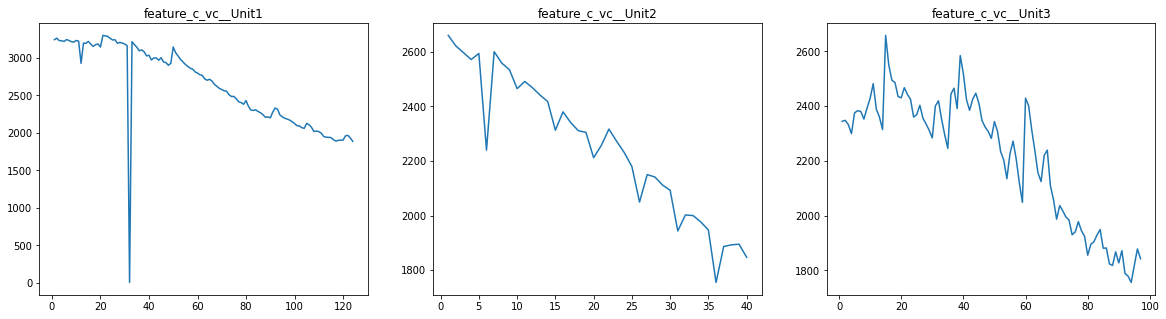

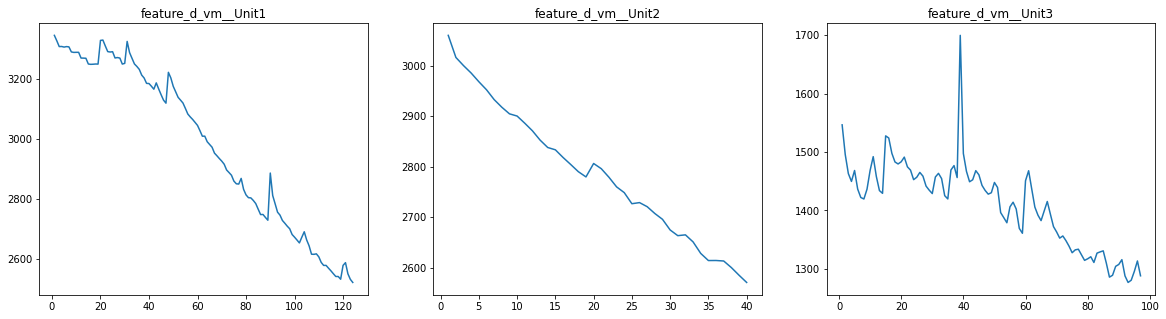

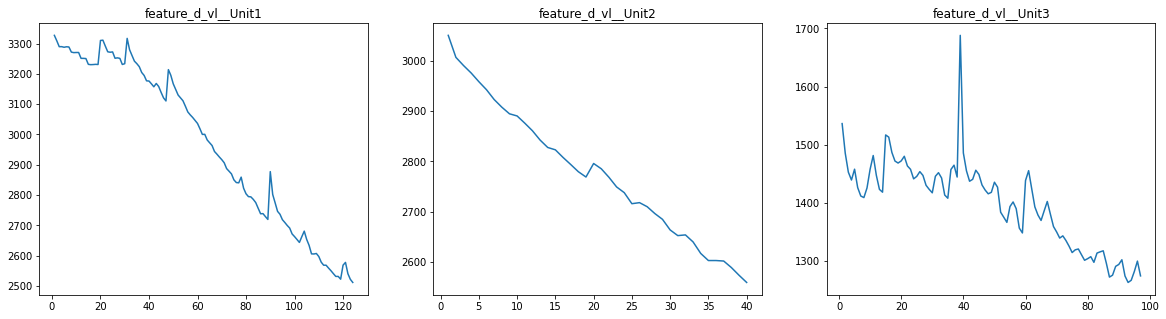

In [ ]:
data = df_train_feature
col = 'feature_c_vm'

for col in feature_col:
  fig = plt.figure(figsize=(20,5))

  ax1 = fig.add_subplot(1, 3, 1)#unit1
  ax2 = fig.add_subplot(1, 3, 2)#unit2
  ax3 = fig.add_subplot(1, 3, 3)#unit3

  data_unit_1 = data[data['unit'] == 'Train_Unit_1']
  data_unit_2 = data[data['unit'] == 'Train_Unit_2']
  data_unit_3 = data[data['unit'] == 'Train_Unit_3']

  ax1.plot(data_unit_1['Cycle_num'], data_unit_1[col])
  ax1.set_title(f'{col}__Unit1')

  ax2.plot(data_unit_2['Cycle_num'], data_unit_2[col])
  ax2.set_title(f'{col}__Unit2')

  ax3.plot(data_unit_3['Cycle_num'], data_unit_3[col])
  ax3.set_title(f'{col}__Unit3')

  plt.show()

# テストデータ

In [ ]:
%time
#データの読み込み(学習)
#充電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_test_charge = data_reading(DATA_DIR, C)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


100%|██████████| 3/3 [00:33<00:00, 11.12s/it]


In [ ]:
%time
#データの読み込み(学習)
#放電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_test_discharge = data_reading(DATA_DIR, C)

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 12.6 µs


100%|██████████| 3/3 [00:25<00:00,  8.54s/it]


In [ ]:
#充電と放電の特徴量のデータセット作成
df_test_feature = pd.merge(df_test_charge, df_test_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_test_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Test_Unit_1,Charge,1,741.86,3476.3,3141.4,Discharge,3338.4,3328.9
1,Test_Unit_1,Charge,2,849.45,3451.6,3164.0,Discharge,3318.3,3308.8
2,Test_Unit_1,Charge,3,803.84,8280.7,3145.7,Discharge,3312.4,3302.7
3,Test_Unit_1,Charge,4,806.83,3102.9,3123.4,Discharge,3296.1,3286.4
4,Test_Unit_1,Charge,5,1004.50,3147.9,3163.0,Discharge,3298.1,3288.2


In [ ]:
feature_col = df_train_feature.columns[3:6]
feature_col = feature_col.append(df_train_feature.columns[7:])
feature_col

Index(['feature_c_vm', 'feature_c_cm', 'feature_c_vc', 'feature_d_vm',
       'feature_d_vl'],
      dtype='object')

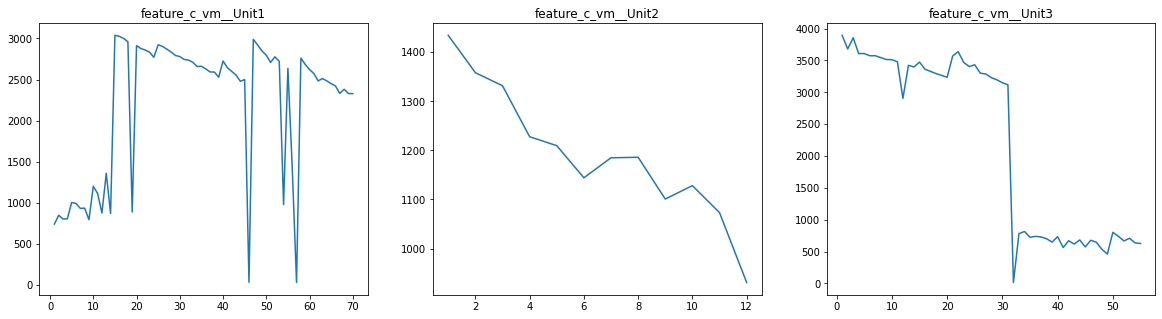

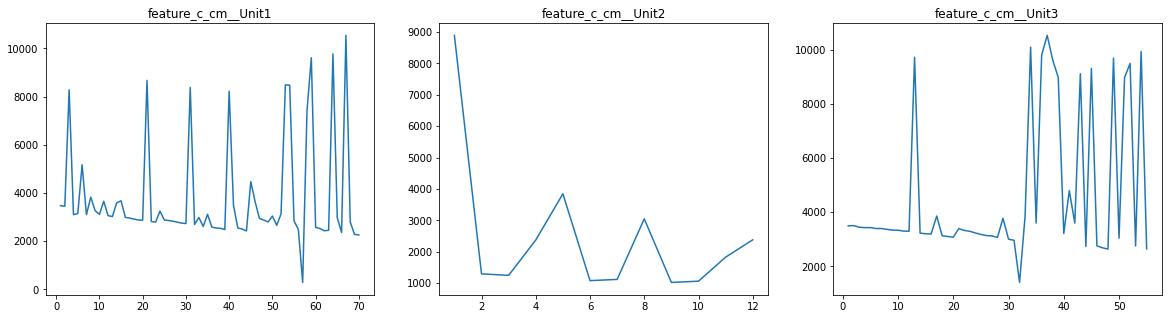

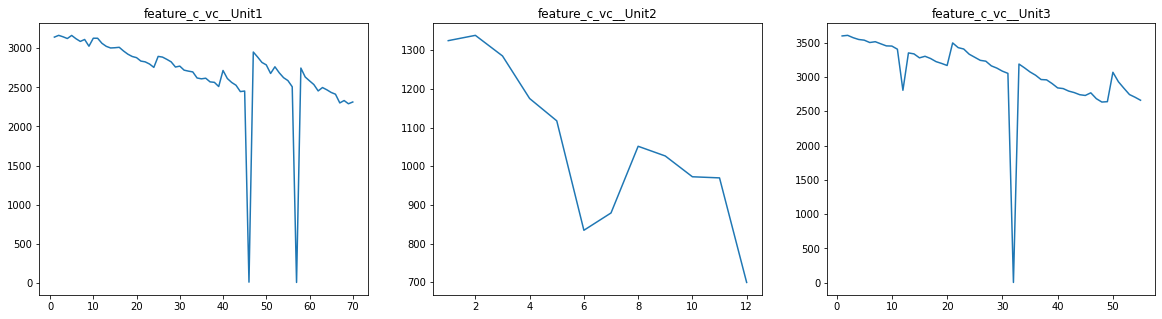

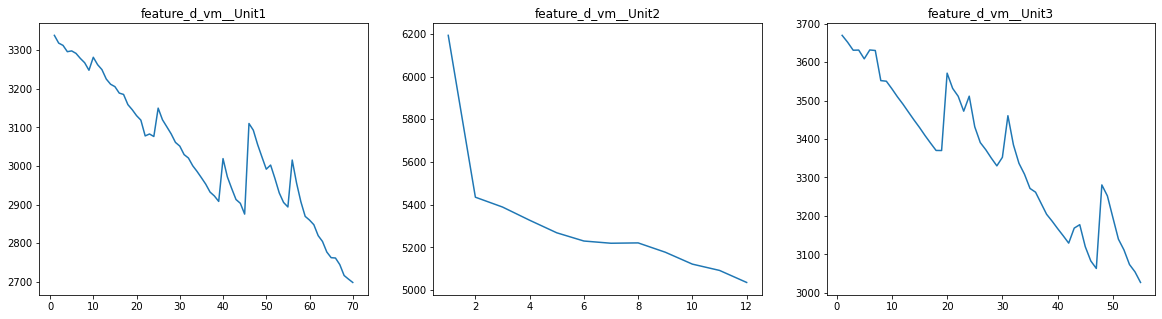

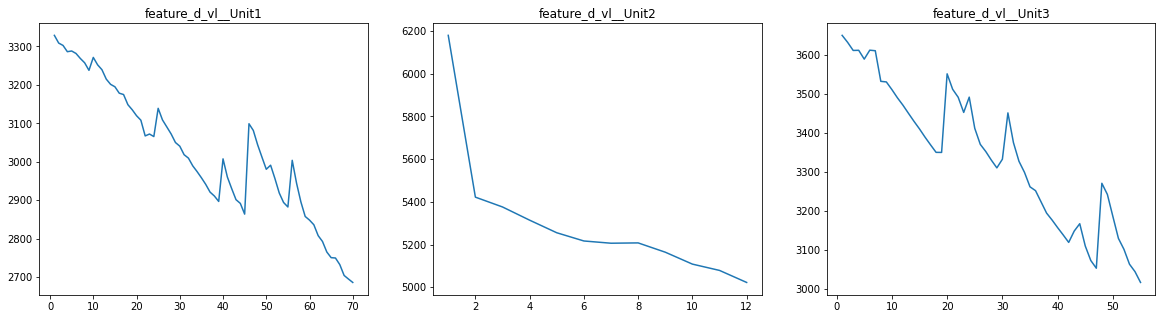

In [ ]:
data = df_test_feature

for col in feature_col:
  fig = plt.figure(figsize=(20,5))

  ax1 = fig.add_subplot(1, 3, 1)#unit1
  ax2 = fig.add_subplot(1, 3, 2)#unit2
  ax3 = fig.add_subplot(1, 3, 3)#unit3

  data_unit_1 = data[data['unit'] == 'Test_Unit_1']
  data_unit_2 = data[data['unit'] == 'Test_Unit_2']
  data_unit_3 = data[data['unit'] == 'Test_Unit_3']

  ax1.plot(data_unit_1['Cycle_num'], data_unit_1[col])
  ax1.set_title(f'{col}__Unit1')

  ax2.plot(data_unit_2['Cycle_num'], data_unit_2[col])
  ax2.set_title(f'{col}__Unit2')

  ax3.plot(data_unit_3['Cycle_num'], data_unit_3[col])
  ax3.set_title(f'{col}__Unit3')

  plt.show()

# 学習データとテストデータとの比較

・特徴量の傾向を比較する。  


In [ ]:
#ユニット毎にデータを分ける
train_unit_1 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_1' ].reset_index()
train_unit_2 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_2' ].reset_index()
train_unit_3 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_3' ].reset_index()

test_unit_1 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_1' ].reset_index()
test_unit_2 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_2' ].reset_index()
test_unit_3 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_3' ].reset_index()

In [ ]:
num_train_unit_1 = 124
num_train_unit_2 = 40
num_train_unit_3 = 97

num_test_unit_1 = 70
num_test_unit_2 = 12
num_test_unit_3 = 55

テストユニット1：訓練ユニット1と傾向似てる特徴量あり

In [ ]:
#訓練ユニット1
pd.merge(test_unit_1, train_unit_1,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,-0.863253,0.344202,-0.406268,-0.917406,-0.908159
Cycle_num,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,-0.863253,0.344202,-0.406268,-0.917406,-0.908159
feature_c_vm_x,0.381496,0.381496,1.000000,0.012115,0.183846,-0.469021,-0.469216,0.381496,-0.274090,-0.079934,-0.130061,-0.170507,-0.163168
feature_c_cm_x,0.086333,0.086333,0.012115,1.000000,0.109707,-0.076761,-0.076677,0.086333,-0.026935,0.263766,0.009646,-0.088035,-0.085992
feature_c_vc_x,-0.529558,-0.529558,0.183846,0.109707,1.000000,0.450505,0.450782,-0.529558,0.497847,-0.207713,0.215759,0.487086,0.480401
feature_d_vm_x,-0.942401,-0.942401,-0.469021,-0.076761,0.450505,1.000000,0.999999,-0.942401,0.815336,-0.331813,0.405549,0.863751,0.855116
feature_d_vl_x,-0.942575,-0.942575,-0.469216,-0.076677,0.450782,0.999999,1.000000,-0.942575,0.815598,-0.331857,0.405570,0.863725,0.855078
index_y,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,-0.863253,0.344202,-0.406268,-0.917406,-0.908159
feature_c_vm_y,-0.863253,-0.863253,-0.274090,-0.026935,0.497847,0.815336,0.815598,-0.863253,1.000000,-0.331671,0.510090,0.748966,0.729880
feature_c_cm_y,0.344202,0.344202,-0.079934,0.263766,-0.207713,-0.331813,-0.331857,0.344202,-0.331671,1.000000,-0.000656,-0.400382,-0.400186


In [ ]:
#訓練ユニット3
pd.merge(test_unit_1, train_unit_3,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,0.435183,0.405254,-0.596602,-0.506042,-0.517829
Cycle_num,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,0.435183,0.405254,-0.596602,-0.506042,-0.517829
feature_c_vm_x,0.381496,0.381496,1.000000,0.012115,0.183846,-0.469021,-0.469216,0.381496,0.458912,0.374423,0.083281,0.039709,0.032571
feature_c_cm_x,0.086333,0.086333,0.012115,1.000000,0.109707,-0.076761,-0.076677,0.086333,-0.067141,0.019133,-0.196384,-0.180483,-0.180110
feature_c_vc_x,-0.529558,-0.529558,0.183846,0.109707,1.000000,0.450505,0.450782,-0.529558,-0.257501,-0.321858,0.275579,0.225879,0.232447
feature_d_vm_x,-0.942401,-0.942401,-0.469021,-0.076761,0.450505,1.000000,0.999999,-0.942401,-0.451496,-0.396389,0.525524,0.414435,0.426174
feature_d_vl_x,-0.942575,-0.942575,-0.469216,-0.076677,0.450782,0.999999,1.000000,-0.942575,-0.451906,-0.396757,0.525331,0.414446,0.426188
index_y,1.000000,1.000000,0.381496,0.086333,-0.529558,-0.942401,-0.942575,1.000000,0.435183,0.405254,-0.596602,-0.506042,-0.517829
feature_c_vm_y,0.435183,0.435183,0.458912,-0.067141,-0.257501,-0.451496,-0.451906,0.435183,1.000000,0.393015,-0.005068,-0.098942,-0.105527
feature_c_cm_y,0.405254,0.405254,0.374423,0.019133,-0.321858,-0.396389,-0.396757,0.405254,0.393015,1.000000,0.017134,-0.028999,-0.035490


テストユニット2；訓練ユニット1or2

In [ ]:
#訓練ユニット1
pd.merge(test_unit_2, train_unit_1,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,-0.601235,-0.082506,-0.556399,-0.923461,-0.923083
Cycle_num,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,-0.601235,-0.082506,-0.556399,-0.923461,-0.923083
feature_c_vm_x,-0.942435,-0.942435,1.000000,0.480477,0.903568,0.822484,0.822657,-0.942435,0.703798,0.015509,0.669772,0.925078,0.925864
feature_c_cm_x,-0.437116,-0.437116,0.480477,1.000000,0.401362,0.834593,0.834440,-0.437116,0.063301,-0.387212,0.018625,0.562320,0.561570
feature_c_vc_x,-0.832043,-0.832043,0.903568,0.401362,1.000000,0.689530,0.689720,-0.832043,0.641316,-0.027024,0.596810,0.752238,0.753053
feature_d_vm_x,-0.776485,-0.776485,0.822484,0.834593,0.689530,1.000000,1.000000,-0.776485,0.381416,-0.094956,0.345547,0.876007,0.876012
feature_d_vl_x,-0.776726,-0.776726,0.822657,0.834440,0.689720,1.000000,1.000000,-0.776726,0.381582,-0.094819,0.345708,0.876149,0.876154
index_y,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,-0.601235,-0.082506,-0.556399,-0.923461,-0.923083
feature_c_vm_y,-0.601235,-0.601235,0.703798,0.063301,0.641316,0.381416,0.381582,-0.601235,1.000000,0.209007,0.989693,0.635881,0.636468
feature_c_cm_y,-0.082506,-0.082506,0.015509,-0.387212,-0.027024,-0.094956,-0.094819,-0.082506,0.209007,1.000000,0.202556,-0.036468,-0.037024


In [ ]:
#訓練ユニット2
pd.merge(test_unit_2, train_unit_2,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.671433,-0.077002,-0.470459,-0.986283,-0.986336
Cycle_num,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.671433,-0.077002,-0.470459,-0.986283,-0.986336
feature_c_vm_x,-0.942435,-0.942435,1.000000,0.480477,0.903568,0.822484,0.822657,-0.942435,-0.738872,0.226105,0.579582,0.945417,0.945537
feature_c_cm_x,-0.437116,-0.437116,0.480477,1.000000,0.401362,0.834593,0.834440,-0.437116,-0.359000,0.012119,0.432293,0.546435,0.545924
feature_c_vc_x,-0.832043,-0.832043,0.903568,0.401362,1.000000,0.689530,0.689720,-0.832043,-0.708077,0.007904,0.682220,0.835322,0.835529
feature_d_vm_x,-0.776485,-0.776485,0.822484,0.834593,0.689530,1.000000,1.000000,-0.776485,-0.459915,0.049868,0.492468,0.856754,0.856458
feature_d_vl_x,-0.776726,-0.776726,0.822657,0.834440,0.689720,1.000000,1.000000,-0.776726,-0.460066,0.049797,0.492494,0.856955,0.856660
index_y,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.671433,-0.077002,-0.470459,-0.986283,-0.986336
feature_c_vm_y,0.671433,0.671433,-0.738872,-0.359000,-0.708077,-0.459915,-0.460066,0.671433,1.000000,-0.467702,-0.595429,-0.644040,-0.644348
feature_c_cm_y,-0.077002,-0.077002,0.226105,0.012119,0.007904,0.049868,0.049797,-0.077002,-0.467702,1.000000,0.181153,0.022466,0.022611


In [ ]:
#訓練ユニット3
pd.merge(test_unit_2, train_unit_3,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.769397,0.208567,0.736836,-0.420009,-0.424380
Cycle_num,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.769397,0.208567,0.736836,-0.420009,-0.424380
feature_c_vm_x,-0.942435,-0.942435,1.000000,0.480477,0.903568,0.822484,0.822657,-0.942435,-0.611502,-0.111973,-0.595875,0.502340,0.506280
feature_c_cm_x,-0.437116,-0.437116,0.480477,1.000000,0.401362,0.834593,0.834440,-0.437116,-0.272868,-0.768738,-0.264188,0.668065,0.668735
feature_c_vc_x,-0.832043,-0.832043,0.903568,0.401362,1.000000,0.689530,0.689720,-0.832043,-0.664728,-0.084790,-0.540672,0.545196,0.547894
feature_d_vm_x,-0.776485,-0.776485,0.822484,0.834593,0.689530,1.000000,1.000000,-0.776485,-0.528003,-0.434783,-0.470078,0.711181,0.713773
feature_d_vl_x,-0.776726,-0.776726,0.822657,0.834440,0.689720,1.000000,1.000000,-0.776726,-0.528265,-0.434659,-0.470302,0.711139,0.713733
index_y,1.000000,1.000000,-0.942435,-0.437116,-0.832043,-0.776485,-0.776726,1.000000,0.769397,0.208567,0.736836,-0.420009,-0.424380
feature_c_vm_y,0.769397,0.769397,-0.611502,-0.272868,-0.664728,-0.528003,-0.528265,0.769397,1.000000,0.245936,0.614366,-0.296262,-0.298979
feature_c_cm_y,0.208567,0.208567,-0.111973,-0.768738,-0.084790,-0.434783,-0.434659,0.208567,0.245936,1.000000,0.386228,-0.223553,-0.223575


テストユニット3

In [ ]:
#訓練ユニット1
pd.merge(test_unit_3, train_unit_1,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,-0.854144,0.265258,-0.237193,-0.862141,-0.843135
Cycle_num,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,-0.854144,0.265258,-0.237193,-0.862141,-0.843135
feature_c_vm_x,-0.881719,-0.881719,1.000000,-0.451795,0.661802,0.865110,0.857849,-0.881719,0.995853,-0.274076,0.420158,0.805546,0.775303
feature_c_cm_x,0.375037,0.375037,-0.451795,1.000000,-0.062942,-0.387593,-0.385049,0.375037,-0.451331,0.330344,0.076121,-0.368687,-0.357825
feature_c_vc_x,-0.544881,-0.544881,0.661802,-0.062942,1.000000,0.501109,0.496035,-0.544881,0.647444,0.044257,0.933028,0.414106,0.390991
feature_d_vm_x,-0.941477,-0.941477,0.865110,-0.387593,0.501109,1.000000,0.999841,-0.941477,0.839432,-0.313252,0.193837,0.954494,0.944698
feature_d_vl_x,-0.938710,-0.938710,0.857849,-0.385049,0.496035,0.999841,1.000000,-0.938710,0.831601,-0.313652,0.188384,0.955214,0.946395
index_y,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,-0.854144,0.265258,-0.237193,-0.862141,-0.843135
feature_c_vm_y,-0.854144,-0.854144,0.995853,-0.451331,0.647444,0.839432,0.831601,-0.854144,1.000000,-0.291969,0.422553,0.790706,0.759583
feature_c_cm_y,0.265258,0.265258,-0.274076,0.330344,0.044257,-0.313252,-0.313652,0.265258,-0.291969,1.000000,0.129387,-0.383583,-0.386972


In [ ]:
#訓練ユニット3
pd.merge(test_unit_3, train_unit_3,
         how = 'inner',
         on = ['Cycle_num']).corr()

,index_x,Cycle_num,feature_c_vm_x,feature_c_cm_x,feature_c_vc_x,feature_d_vm_x,feature_d_vl_x,index_y,feature_c_vm_y,feature_c_cm_y,feature_c_vc_y,feature_d_vm_y,feature_d_vl_y
index_x,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,0.551942,0.663511,-0.319640,-0.265268,-0.278359
Cycle_num,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,0.551942,0.663511,-0.319640,-0.265268,-0.278359
feature_c_vm_x,-0.881719,-0.881719,1.000000,-0.451795,0.661802,0.865110,0.857849,-0.881719,-0.432792,-0.609185,0.230863,0.161176,0.172781
feature_c_cm_x,0.375037,0.375037,-0.451795,1.000000,-0.062942,-0.387593,-0.385049,0.375037,0.196064,0.305880,-0.104398,-0.005830,-0.011141
feature_c_vc_x,-0.544881,-0.544881,0.661802,-0.062942,1.000000,0.501109,0.496035,-0.544881,-0.347490,-0.411124,0.085280,0.112287,0.119470
feature_d_vm_x,-0.941477,-0.941477,0.865110,-0.387593,0.501109,1.000000,0.999841,-0.941477,-0.494095,-0.602350,0.225870,0.197632,0.210028
feature_d_vl_x,-0.938710,-0.938710,0.857849,-0.385049,0.496035,0.999841,1.000000,-0.938710,-0.494268,-0.598858,0.223748,0.197866,0.210225
index_y,1.000000,1.000000,-0.881719,0.375037,-0.544881,-0.941477,-0.938710,1.000000,0.551942,0.663511,-0.319640,-0.265268,-0.278359
feature_c_vm_y,0.551942,0.551942,-0.432792,0.196064,-0.347490,-0.494095,-0.494268,0.551942,1.000000,0.425618,0.000154,-0.105878,-0.113591
feature_c_cm_y,0.663511,0.663511,-0.609185,0.305880,-0.411124,-0.602350,-0.598858,0.663511,0.425618,1.000000,-0.091268,-0.068565,-0.077781


まとめ  
テストユニット1：訓練ユニット1と似ている。
feature_d_vm と feature_d_vm or feature_d_vlで、ほぼ説明できそう。 

テストユニット2：訓練ユニット2と似ている。
feature_c_vm と feature_d_vm or feature_d_vlで、ほぼ説明できそう。　　

テストユニット3：訓練ユニット1と似ている。
feature_d_vm	feature_d_vl と feature_d_vm	feature_d_vlで、ほぼ説明できそう。　

あるユニットのある特徴量でほぼ予測できそうなので、時系列的なモデルを作成する。  
モデルは、LSTMをkerasで試す。